In [1]:
import sys
import pprint
pprint.pprint(sys.path)
sys.path.append('/home/ksato/ExternalSSD1T/anaconda3/envs/for_tabian/lib/python3.8/site-packages/')

['/home/ksato/dev/tabian/pca_test',
 '',
 '/opt/ros/foxy/lib/python3.8/site-packages',
 '/usr/lib/python38.zip',
 '/usr/lib/python3.8',
 '/usr/lib/python3.8/lib-dynload',
 '/home/ksato/.local/lib/python3.8/site-packages',
 '/usr/local/lib/python3.8/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/lib/python3/dist-packages/IPython/extensions',
 '/home/ksato/.ipython']


In [15]:
# -*- coding: utf-8 -*-

import cv2
import numpy as np
import matplotlib.pyplot as plt 

# 画像１
img1 = cv2.imread("./images/tokino-kane1.png")
img2 = cv2.imread("./images/tokino-kane2.jpg")
img3 = cv2.imread("./images/tokino-kane3.jpg")
img4 = cv2.imread("./images/tokino-kane4.jpg")
# 画像２
# img2 = cv2.imread("img2.jpg")

# A-KAZE検出器の生成
detector = cv2.AKAZE_create()

In [16]:
# matcher = cv2.BFMatcher(cv2.NORM_HAMMING)
matcher = cv2.BFMatcher()

In [17]:
kp1, desc1 = detector.detectAndCompute(img1, None)
kp2, desc2 = detector.detectAndCompute(img2, None)
kp3, desc3 = detector.detectAndCompute(img3, None)
kp4, desc4 = detector.detectAndCompute(img4, None)

In [18]:
print(desc1.shape)
print(desc2.shape)
print(desc3.shape)
print(desc4.shape)

(16523, 61)
(6753, 61)
(2091, 61)
(8861, 61)


In [19]:
matcher = cv2.BFMatcher()
matches = matcher.knnMatch(desc1, desc4, k=2)

In [135]:
matched_idx_kp_dict = {}
lowes_ratio = 0.75
for idx, (m, n) in enumerate(matches):
    if m.distance < lowes_ratio * n.distance:
        matched_idx_kp_dict[idx] = m, n
matched_idx_list = list(matched_idx_kp_dict.keys())
matched_keypoints = [[m, n] for m, n in matched_idx_kp_dict.values()]
matched_keypoints = sorted(matched_keypoints, key = lambda x:x[0].distance)

In [136]:
print(len(matched_keypoints))
# print(matched_keypoints)

70


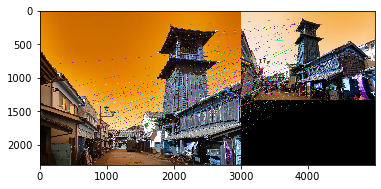

In [137]:
knn_img = cv2.drawMatchesKnn(img1, kp1, img4, kp4, matched_keypoints, None, flags=2)
# knn_img = cv2.resize(knn_img, dsize=None, fx=2.0, fy=2.0)
plt.imshow(knn_img)
plt.show()

In [138]:
import pandas as pd

In [139]:
def extract_attr_from_kp(kp):
    # ret_list = (kp.angle, kp.class_id, kp.convert, kp.octave, kp.overlap, kp.pt, kp.response, kp.size)
    # print(kp.octave)
    ret_list = (kp.angle, kp.class_id, kp.pt[0], kp.pt[1], kp.response, kp.size)
    return ret_list
    
# idx_list
matched_kp1_list = []
# print(dir(cv2.KeyPoint))
for idx, curr_kp1 in enumerate(kp1):
    if idx in matched_idx_list:
        # print(dir(curr_kp1))
        curr_data = extract_attr_from_kp(curr_kp1)
        matched_kp1_list.append(curr_data)
    
matched_df1 = pd.DataFrame(matched_kp1_list)
# df2 = pd.DataFrame(desc2)

In [140]:
matched_df1.head()

,0,1,2,3,4,5
0,18.495687,0,2041.711792,476.888062,0.001270,4.8
1,2.236726,0,2121.703125,677.954468,0.003662,4.8
2,144.327087,0,583.940552,1303.676392,0.002057,4.8
3,189.890778,0,2471.252441,1309.493286,0.005079,4.8
4,253.378479,0,1614.500122,1672.270752,0.006497,4.8


In [141]:
import sklearn #機械学習のライブラリ
from sklearn.decomposition import PCA #主成分分析器

In [142]:
# 標準化
dfs = matched_df1.iloc[:, 1:].apply(lambda x: (x-x.mean())/x.std(), axis=0)

In [152]:
#主成分分析の実行
pca = PCA()
pca.fit(dfs)
# データを主成分空間に写像
feature = pca.transform(dfs)

In [153]:
pd.DataFrame(feature, columns=["PC{}".format(x + 1) for x in range(len(dfs.columns))]).head()

,PC1,PC2,PC3,PC4,PC5
0,-0.813747,1.903268,0.726038,-2.078100,0.025767
1,-0.776477,2.005118,0.478338,-1.360992,0.079448
2,-1.304245,-0.328584,-0.642647,-1.197384,0.266120
3,-0.999639,1.666405,0.813178,0.106953,0.137877
4,-1.169313,0.630079,-0.190251,0.538054,0.281670


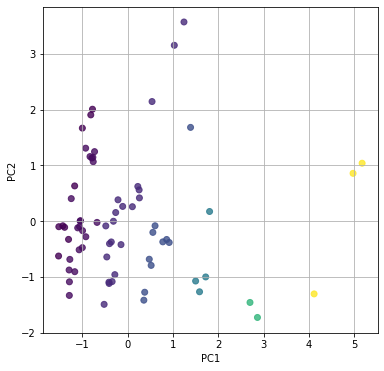

In [154]:
# 第一主成分と第二主成分でプロットする
plt.figure(figsize=(6, 6))
plt.scatter(feature[:, 0], feature[:, 1], alpha=0.8, c=list(matched_df1.iloc[:, 5]))
plt.grid()
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [155]:
# 寄与率
pd.DataFrame(pca.explained_variance_ratio_, index=["PC{}".format(x + 1) for x in range(len(dfs.columns))])

,0
PC1,0.410563
PC2,0.237774
PC3,0.181839
PC4,0.162640
PC5,0.007185


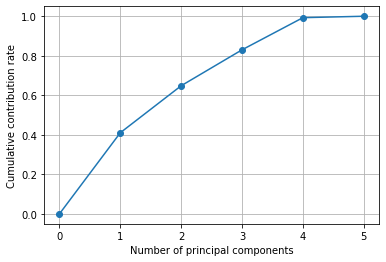

In [156]:
# 累積寄与率を図示する
import matplotlib.ticker as ticker
plt.gca().get_xaxis().set_major_locator(ticker.MaxNLocator(integer=True))
plt.plot([0] + list( np.cumsum(pca.explained_variance_ratio_)), "-o")
plt.xlabel("Number of principal components")
plt.ylabel("Cumulative contribution rate")
plt.grid()
plt.show()